In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
data = pd.read_excel(r"20210922Renter.xlsx")

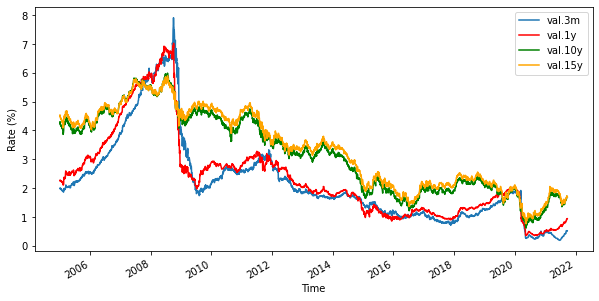

In [3]:
plt.figure(figsize=(10,5))
ax = plt.gca()
data.plot(kind='line',x='date.3m', y='val.3m', ax=ax)
data.plot(kind='line',x='date.1y', y='val.1y', color='red', ax=ax)
data.plot(kind='line',x='date.10y', y='val.10y', color='green', ax=ax)
data.plot(kind='line',x='date.15y', y='val.15y', color='orange', ax=ax)
plt.ylabel("Rate (%)")
plt.xlabel("Time")
plt.show()

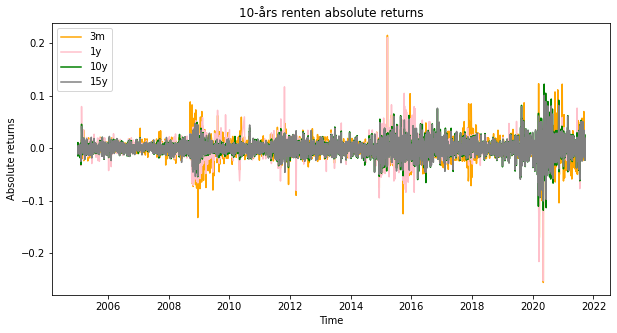

In [4]:

#absolute returns (easier to see daily change)
data_3m_returns = data['val.3m'].pct_change()
data_1y_returns = data['val.1y'].pct_change()
data_10y_returns = data['val.10y'].pct_change()
data_15y_returns = data['val.15y'].pct_change()

#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(data['date.3m'],data_3m_returns, color='orange', label="3m")
plt.plot(data['date.1y'],data_1y_returns, color='pink', label="1y")
plt.plot(data['date.10y'],data_10y_returns, color='green', label="10y")
plt.plot(data['date.15y'],data_15y_returns, color='grey', label="15y")
plt.title('10-års renten absolute returns')
plt.ylabel("Absolute returns")
plt.xlabel("Time")
plt.legend()
plt.show()


# En-faktor model: 

Vi modellerer vanligvis renten med en short rate model. Short rate er renten vi kan låne penger for på en infinitesimal kort tidsperiode. 
## Vasicek


$$dr= \kappa (\theta - r) dt + \sigma dW$$

hvor $W$ er tilfeldig markedsrisiko, $\kappa$ er farten på reversjonen mot forventningsverdien, $\theta$ er long-term level av forventningsverdien, og $\sigma$ er volatiliteten.

Leddet $\kappa (\theta - r)$ kalles drift factor og representerer forventet instant forandring i renten for tiden t.


Løsning:

$$ 
r_ti = r_t(i-1) exp(-\kappa(T_i-t_{i-1})) + \theta (1- exp(-k\kappa(t_i - t_{i-1}))) + Z\sqrt{\frac{\sigma^2(1-exp(-2\kappa(t_i-t_{i-1}))}{2\kappa}} 
$$

der $Z\sim N(0,1)$



 ### Generelt om enfaktormodeller
 
 Enfaktormodeller studerer oppførselen av renter med kortest mulig innskuddsbetaling, altså spot renten (dette er den stokastiske variabelen i modellen). 

 Målet med enfaktormodellen er finne prisen på en zcb ettersom denne er avhengig av spot renten. 
 Dette kan gjøres ved å finne parameterne til enfaktormodellen ved feks MLE basert på historisk data fra en spesifikk rente (her 3 mnd-renten).

 $$B(t,T) = Z \exp({-\int_{t}^{T} r(s)ds})$$

Enfaktormodeller er nyttige for å analysere utviklingen av renten over tid via yield curves. 

$$   Y(t,T) = \frac{logB(t,T)}{T-t}$$

der $Y(t,T)$ er utbytte (yield) fra en obligasjon på tiden t med maturity $T$. Yield curven er vist som en funksjon av $t-T$.

Fordeler: 
obligasjonspriser matcher markedsprisene ettersom modellen er basert på disse. Men det gjørogså at modellparametrne må stadig kalibreres ettersom det er høy curvature på den korte enden av yield curven.

Ulemper: 
alle obligasjonspriser er relatert til samme random factor og er dermed mer korrelerte i modellen enn i virkeligheten.

In [5]:
def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):
  # Implements above closed form solution
  val1 = np.exp(-1*kappa*dt)
  val2 = (sigma**2)*(1-val1**2) / (2*kappa)
  out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
  return out

# Vasicek simulation short rate
def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
  short_r = [0]*N # Create array to store rates
  short_r[0] = r0 # Initialize rates at $r_0$
  for i in range(1,N):
    short_r[i]=VasicekNextRate(short_r[i-1],kappa, theta, sigma, dt)
  return short_r

# Vasicek multi-simulation
def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
  sim_arr = np.ndarray((N, M))
  for i in range(0,M):
    sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
  return sim_arr

# Maximum Likelihood Estimation to calibrate parameters
def VasicekCalibration(rates, dt=1/252):
  n = len(rates)
  Ax = sum(rates[0:(n-1)])
  Ay = sum(rates[1:n])
  Axx = np.dot(rates[0:(n-1)], rates[0:(n-1)])
  Axy = np.dot(rates[0:(n-1)], rates[1:n])
  Ayy = np.dot(rates[1:n], rates[1:n])
  theta = (Ay * Axx - Ax * Axy) / (n * (Axx - Axy) - (Ax**2 - Ax*Ay))
  kappa = -np.log((Axy - theta * Ax - theta * Ay + n * theta**2) / (Axx - 2*theta*Ax + n*theta**2)) / dt
  a = np.exp(-kappa * dt)
  sigmah2 = (Ayy - 2*a*Axy + a**2 * Axx - 2*theta*(1-a)*(Ay - a*Ax) + n*theta**2 * (1-a)**2) / n
  sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
  r0 = rates[n-1]
  return [kappa, theta, sigma, r0]


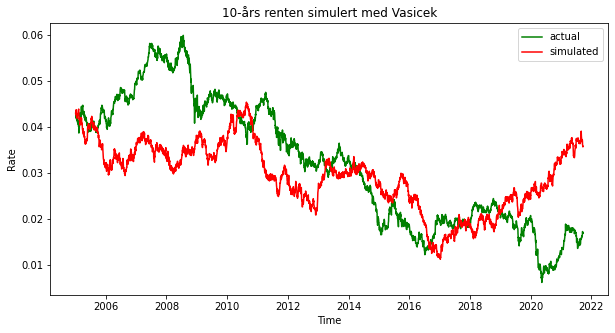

In [6]:
#10års renten

#hent ut parametere
params=VasicekCalibration(data['val.10y'].dropna()/100)
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = data['val.10y'][0]/100

#hent ut x- og y-verdier
days = len(data['date.10y'])
t = data['date.10y']
test_sim = VasicekSim(days, r0, kappa, theta, sigma, 1/252)

#plot av simulert vs. faktisk 10-års rente
plt.figure(figsize=(10,5))
plt.plot(t,data['val.10y']/100, color='green', label='actual')
plt.plot(t,test_sim, color='red', label='simulated')
plt.title('10-års renten simulert med Vasicek')
plt.ylabel("Rate")
plt.xlabel("Time")
plt.legend()
plt.show()

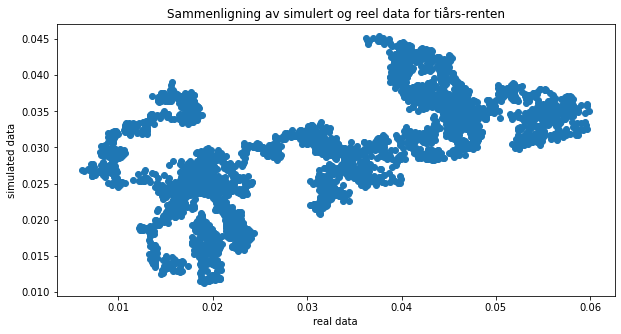

In [7]:
#scatter plot of simulated and real line 
plt.figure(figsize=(10,5))
plt.scatter(x =data['val.10y']/100 , y=test_sim)
plt.title('Sammenligning av simulert og reel data for tiårs-renten')
plt.ylabel("simulated data")
plt.xlabel("real data")
plt.show()



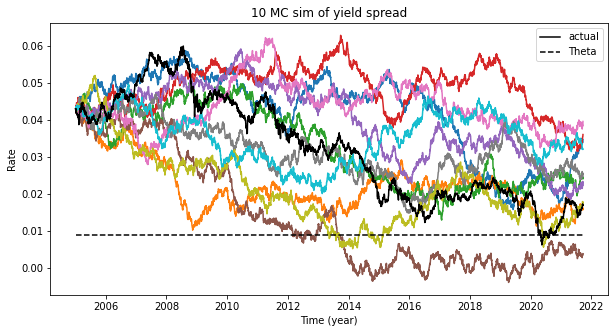

In [8]:
#monte carlo 

M = 10
rates_arr = VasicekMultiSim(M, days, r0, kappa, theta, sigma)

plt.figure(figsize=(10,5))
plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = t[0], xmax=t[len(t)-1], zorder=10, linestyles = 'dashed', label='Theta', color="black")
plt.plot(t,data['val.10y']/100, color='black', label='actual')
plt.ylabel("Rate")
plt.xlabel("Time (year)")
plt.title('10 MC sim of yield spread')
plt.legend()
plt.show()

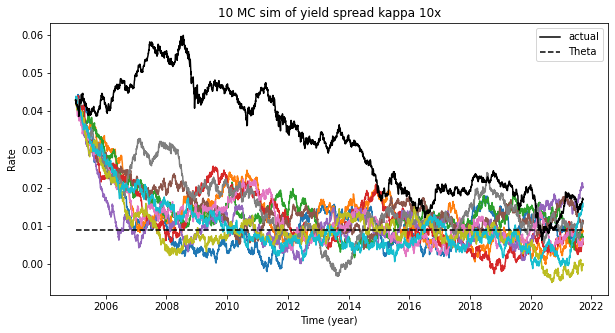

In [9]:
#nå: leke med parametere, feks theta:

rates_10kappa = VasicekMultiSim(10, days, r0, kappa*10, theta, sigma)


plt.figure(figsize=(10,5))
plt.plot(t,rates_10kappa)
plt.hlines(y=theta, xmin = t[0], xmax=t[len(t)-1], zorder=10, linestyles = 'dashed', label='Theta', color="black")
plt.plot(t,data['val.10y']/100, color='black', label='actual')
plt.ylabel("Rate")
plt.xlabel("Time (year)")
plt.title('10 MC sim of yield spread kappa 10x')
plt.legend()
plt.show()


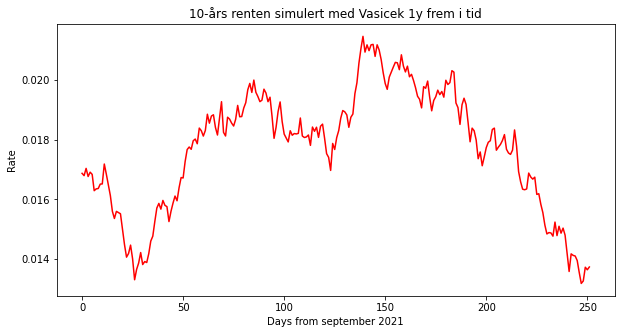

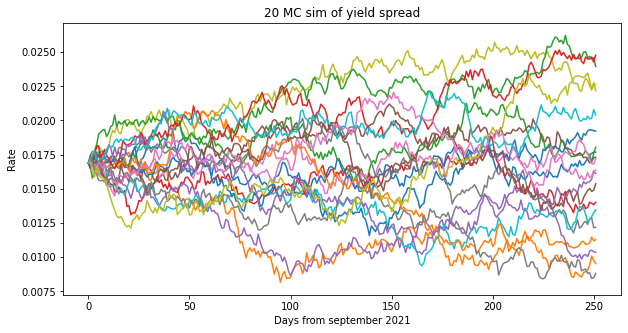

In [10]:
#10års frem i tid
days = len(data['date.10y'])
rend = data['val.10y'][days-1]/100

N = 252*1 #1y fram i tid
t = np.arange(0,N)
test_sim_future = VasicekSim(N, rend, kappa, theta, sigma, 1/252)

#plot av simulert vs. faktisk 10-års rente
plt.figure(figsize=(10,5))
plt.plot(t,test_sim_future, color='red')
plt.title('10-års renten simulert med Vasicek 1y frem i tid')
plt.ylabel("Rate")
plt.xlabel("Days from september 2021")
plt.show()

rates_future = VasicekMultiSim(500, N, rend, kappa, theta, sigma)

plt.figure(figsize=(10,5))
plt.plot(t,rates_future[:,0:20])
# plt.hlines(y=theta, xmin = t[0], xmax=t[len(t)-1], zorder=10, linestyles = 'dashed', label='Theta', color="black")
plt.ylabel("Rate")
plt.xlabel("Days from september 2021")
plt.title('20 MC sim of yield spread')
plt.show()


Text(0.5, 1.0, 'Fordelingen av simuleringer for rentedata 1 år frem i tid, p(r(t1)|r(t0);H)')

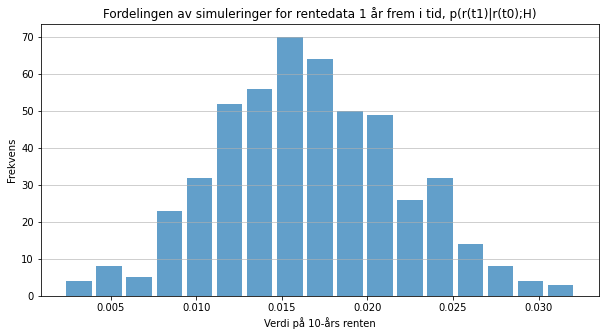

In [11]:
# velg siste dag (altså dag nr. 251)
# bruker parametere basert på historisk data fra 10-årsrenten funnet ved MLE
t1 = rates_future[-1,:]
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(x=t1, bins='auto',
                            alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Verdi på 10-års renten')
plt.ylabel('Frekvens')
plt.title('Fordelingen av simuleringer for rentedata 1 år frem i tid, p(r(t1)|r(t0);H)')



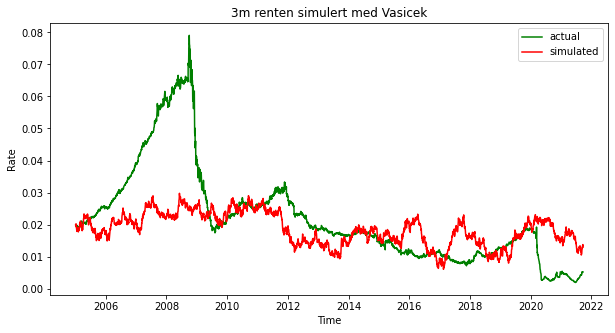

In [32]:
#3mnd renten


#hent ut parametere
params=VasicekCalibration(data['val.3m'].dropna()/100)
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = data['val.3m'][0]/100 #Start-dato for obligasjonskjøp

#hent ut x- og y-verdier
days = len(data['date.3m'])
t = data['date.3m']
test_sim = VasicekSim(days, r0, kappa, theta, sigma, 1/252)

#plot av simulert vs. faktisk 10-års rente
plt.figure(figsize=(10,5))
plt.plot(t,data['val.3m']/100, color='green', label='actual')
plt.plot(t,test_sim, color='red', label='simulated')
plt.title('3m renten simulert med Vasicek')
plt.ylabel("Rate")
plt.xlabel("Time")
plt.legend()
plt.show()

0.0172


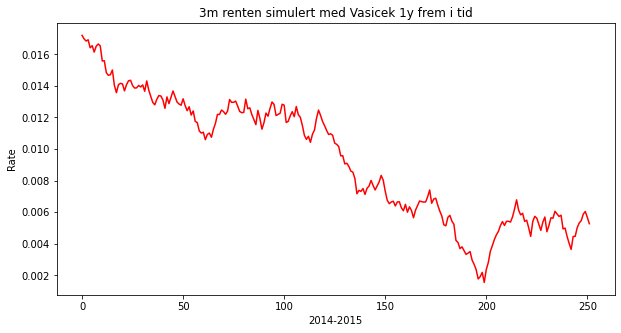

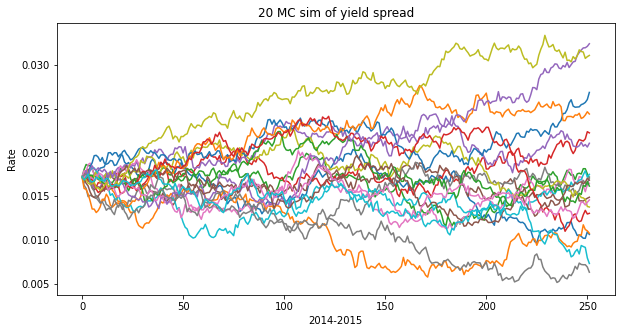

Text(0.5, 1.0, 'Fordelingen av simuleringer for rentedata 1 år frem i tid (2015), p(r(t1)|r(t0);H)')

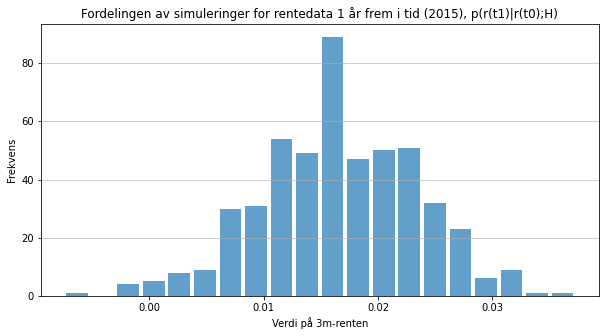

In [43]:
#3ms renten frem i tid fra midt i perioden 2006-2022
days = len(data['date.3m'])
rend = data['val.3m'][int(days/2)]/100
print(rend)

N = 252*1 #1y fram i tid
t = np.arange(0,N)
test_sim_future = VasicekSim(N, rend, kappa, theta, sigma, 1/252)

#plot av simulert vs. faktisk 10-års rente
plt.figure(figsize=(10,5))
plt.plot(t,test_sim_future, color='red')
plt.title('3m renten simulert med Vasicek 1y frem i tid')
plt.ylabel("Rate")
plt.xlabel("2014-2015")
plt.show()

rates_future = VasicekMultiSim(500, N, rend, kappa, theta, sigma)

plt.figure(figsize=(10,5))
plt.plot(t,rates_future[:,0:20])
# plt.hlines(y=theta, xmin = t[0], xmax=t[len(t)-1], zorder=10, linestyles = 'dashed', label='Theta', color="black")
plt.ylabel("Rate")
plt.xlabel("2014-2015")
plt.title('20 MC sim of yield spread')
plt.show()

#historgram 
t1 = rates_future[-1,:]
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(x=t1, bins='auto',
                            alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Verdi på 3m-renten')
plt.ylabel('Frekvens')
plt.title('Fordelingen av simuleringer for rentedata 1 år frem i tid (2015), p(r(t1)|r(t0);H)')



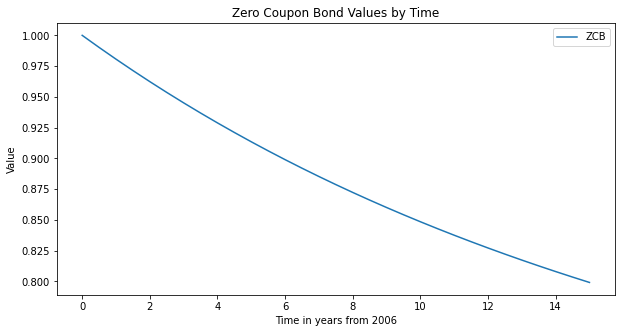

In [50]:
#pris en zero coupon bond med Vasicek modellen
#N, rend, kappa, theta, sigma, 1/252
def zcb_price(kappa,theta,sigma,tau,r0=0,):
    B = (1-np.exp(-kappa*tau))/kappa
    A = np.exp((theta-(sigma**2)/(2*kappa**2))*(B-tau) - (sigma**2)/(4*kappa)*(B**2))
    return A*np.exp(-r0*B)


#initial rate 
r0 = data['val.3m'][0]/100 #Start-dato for obligasjonskjøp


#sett r0 lik startdatoen i 2006 brukt over
#bruker parameterne fra Vasicek
#zero coupon bond pricing
Ts  = np.r_[0.0:15.5:0.5] #tid fra nå til 15 år frem med 0,5 års tidsintervall (ulike maturity datoer)
zcbs = [zcb_price(kappa, theta, sigma, t, r0) for t in Ts]

plt.figure(figsize=(10,5))
plt.title("Zero Coupon Bond Values by Time")
plt.plot(Ts, zcbs,label='ZCB')
plt.ylabel("Value")
plt.xlabel("Time in years from 2006")
plt.legend()
plt.show()
    

Prisen på en Zero coupon bond avhenger av rente-prisene. Som regel er face value en fastsatt verdi på obligasjonen som låner betaler tilbake ved maturity date. Issue price som utlåner betaler idet obligasjonen startes bestemmes av renten. 
Her antar vi at Face Value er 1 kr.
Vi ser at issue price synker med tiden noe som gir mening da en zero coupon bond ikke har rente eller copouns så må man få et avslag i issue price alt etter hvor lenge man binder seg til å låne bort penger.
Altså differansen mellom face value og issue pris vokser ettersom man har lengre tidsintervall / seinere maturity date. 

Prisen på en zcb er: $$ \frac{\text{Face value}}{(1+r)^{T-t}} $$ 





In [58]:
def zero_coupon_bond(r, t, par=1):
    # t: time to maturity
    # r is simulated interest rate
    # par is par value, set to 1
    return par/(1+r)**t


#etterprøver pris på en zcb for t=1 år fra r0
#zero coupon bond pris for 1 år maturity date basert på simulert rente fra 2006
sim_pris_1y = zcbs[2] # to steg per år, 
print("simulert", sim_pris_1y)


#bruker renten for et år frem i tid fra 2006 og regner ut zero coupon bond pris for face value 1kr og maturity date 1 år frem i tid med bruk av faktisk rente 1 år frem i tid
faktisk_r_1y = data['val.3m'][251]/100
faktisk_pris_1y = zero_coupon_bond(faktisk_r_1y, 1)
print("faktisk", faktisk_pris_1y)



simulert 0.9806575498920156
faktisk 0.9751340809361286


Prisen på obligasjonen gitt at vi vet renten om et år er litt lavere enn prisen på obligasjonen basert på simulert rente et år frem tid.
Det vil si at den som kjøper obligasjonen (låner ut penger) betaler faktisk en for høy issue price og får dermed lavere utbytte grunnet simuleringsusikkerheten. 
Det vil si at renten er simulert til å være litt for lav enn det den viser seg å være et år frem i tid, basert på faktisk data. 

Ser på plottet under at dette stemmer for året 2007. Her er simulert rente lavere enn faktisk rente. 

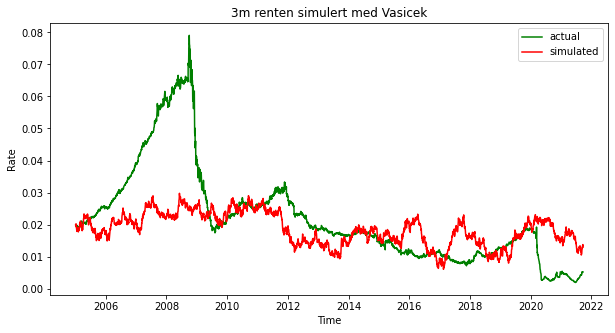

In [60]:
t = data['date.3m']

#plot av simulert vs. faktisk 10-års rente
plt.figure(figsize=(10,5))
plt.plot(t,data['val.3m']/100, color='green', label='actual')
plt.plot(t,test_sim, color='red', label='simulated')
plt.title('3m renten simulert med Vasicek')
plt.ylabel("Rate")
plt.xlabel("Time")
plt.legend()
plt.show()